In [1]:
#import libraries
import numpy as np
import geopandas as gpd
import shapely 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import sklearn

In [2]:
user_dir = '/Users/jyontika/Desktop/'
data_dir = os.path.join(user_dir, 'opioid-overdose-models/cook-county/data/')

csv_path = os.path.join(data_dir, 'cook_county_gdf_year.csv')
cook_county_gdf = pd.read_csv(csv_path) 

In [3]:
cook_county_gdf.year.isna().sum()

56

In [4]:
cook_county_gdf['year'].fillna(9999, inplace=True)

In [5]:
cook_county_gdf[cook_county_gdf['year']==9999].shape #56

(56, 15)

In [6]:
cook_county_gdf['geoid'].nunique() #now we have all census tracts (1332)

1332

In [7]:
columns_to_keep = ['STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry']

#aggregate deaths, group by year
gdf_annual = cook_county_gdf.groupby(['geoid', 'year']).agg({'deaths': 'sum', **{col: 'first' for col in columns_to_keep}}).reset_index()

### Making DF square - one year for each tract



In [8]:
gdf_annual.loc[gdf_annual['year'] == 9999, 'deaths'] = 0

# Replace 9999 with 2015 in the 'year' column
gdf_annual['year'].replace(9999, 2015, inplace=True)

In [9]:
##uses nested for loops - not exactly the most efficient 

years = range(2015, 2024)
updated_rows = []

for tract in gdf_annual['geoid'].unique():
    existing_years = set(gdf_annual[gdf_annual['geoid'] == tract]['year'])
    missing_years = set(years) - existing_years
    
    for year in missing_years:
        new_row = {'geoid': tract, 
                   'year': year, 
                   'deaths': 0}
        
        updated_rows.append(new_row)

gdf_annual = pd.concat([gdf_annual, pd.DataFrame(updated_rows)], ignore_index=True)

In [10]:
unique_tracts = gdf_annual['geoid'].unique()

for tract in unique_tracts:
    tract_rows = gdf_annual[gdf_annual['geoid'] == tract]
    non_na_row = tract_rows.dropna().iloc[0]  # Get the first row without any NAs
    
    for column in columns_to_keep:
        gdf_annual.loc[(gdf_annual['geoid'] == tract) & gdf_annual[column].isna(), column] = non_na_row[column]

In [11]:
gdf_annual.shape #should be 11988, 15

(12174, 15)

In [12]:
#Any NAs in data frame?

has_na = gdf_annual.isna().any().any()

if has_na:
    print("There are missing values in the dataframe.")
else:
    print("There are no missing values in the dataframe.")


There are no missing values in the dataframe.


In [13]:
#confirms all years for each geoid present
years = range(2015, 2024)  

for geoid in gdf_annual['geoid'].unique():
    for year in years:
        if not ((gdf_annual['geoid'] == geoid) & (gdf_annual['year'] == year)).any():
            print("Missing row for geoid {} in year {}".format(geoid, year))


In [14]:
#convert back to gdf
from shapely import wkt

gdf_annual['geometry'] = gdf_annual['geometry'].apply(wkt.loads)

gdf_annual = gpd.GeoDataFrame(gdf_annual, geometry='geometry')
gdf_annual.crs = {'init': 'EPSG:4269'}
type(gdf_annual)

/Users/jyontika/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


geopandas.geodataframe.GeoDataFrame

In [15]:
#create timestep column
gdf_annual = gdf_annual.sort_values(by=['geoid', 'year'])

# Group the DataFrame by 'geoid' and assign a unique timestep value based on the order of years
gdf_annual['timestep'] = gdf_annual.groupby('geoid').cumcount() + 1

In [16]:
gdf_annual.columns = ['geoid', 'year', 'deaths', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'lat',
       'lon', 'geometry', 'timestep']


In [17]:
gdf_annual = gdf_annual[gdf_annual['year']!=2014] #take out 2014 because ME only started collecting in 08/2014
gdf_annual = gdf_annual[gdf_annual['year'] != 2023] #2023 not complete yet

## Tables & Graphs

In [18]:
gdf_annual['year'] = pd.to_datetime(gdf_annual['year'].astype(int).astype(str), format='%Y').dt.year

In [19]:
sparsity_df = pd.DataFrame(columns=['year', 'Total Deaths', 'Sparsity Rate'])

years = range(2015, 2023)
for year in years:
    year_df = gdf_annual[gdf_annual['year'] == year]
    zero_deaths_count = year_df[year_df['deaths'] == 0].shape[0]
    total_count = year_df.shape[0]
    sparsity_rate = (zero_deaths_count / total_count) * 100
    total_deaths = year_df['deaths'].sum()
    sparsity_df = pd.concat([sparsity_df, pd.DataFrame({'year': [year], 'Total Deaths': [total_deaths], 'Sparsity Rate': [sparsity_rate]})], ignore_index=True)


raw_sparsity = sparsity_df['Sparsity Rate']
sparsity_df['Sparsity Rate'] = sparsity_df['Sparsity Rate'].round(3).astype(str) + '%'
print(sparsity_df)

   year Total Deaths Sparsity Rate
0  2015          616       67.342%
1  2016         1029       53.754%
2  2017         1109       53.303%
3  2018         1078       54.429%
4  2019         1210       52.102%
5  2020         1687       43.619%
6  2021         1791       43.168%
7  2022         1851       43.018%


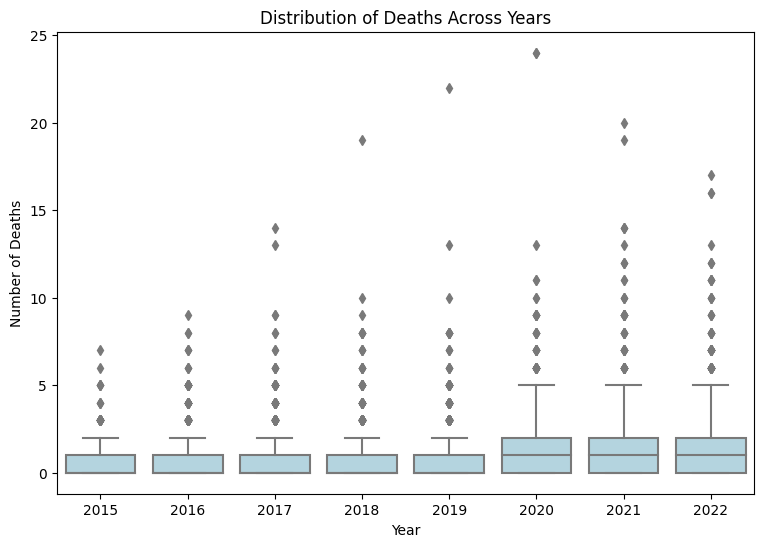

In [20]:
plt.figure(figsize=(9, 6))
df_no23 = gdf_annual[gdf_annual['year'] != 2023]
sns.boxplot(x='year', y='deaths', data=df_no23, color='lightblue')

plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.title('Distribution of Deaths Across Years')

plt.show()


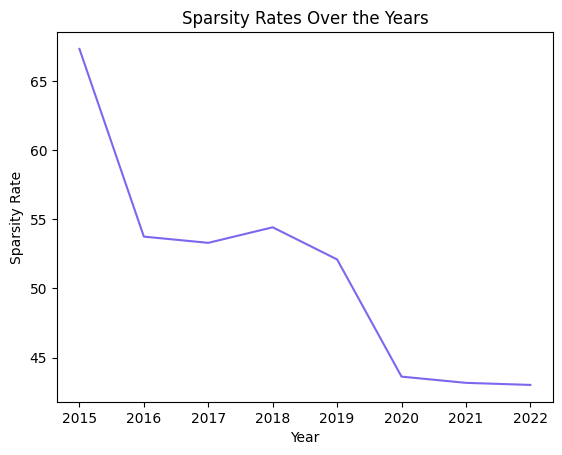

In [21]:
plt.rcParams['font.family'] = 'sans-serif'
plt.plot(range(2015, 2023), raw_sparsity, color='mediumslateblue')
plt.xlabel('Year')
plt.ylabel('Sparsity Rate')
plt.title('Sparsity Rates Over the Years')
plt.grid(False)

plt.show()

### store gdf

In [22]:
gdf_annual.to_csv(csv_path, index=False)